# GradOptics Tutorial

This notebook steps through basic examples using [gradoptics](https://github.com/Magis-slac/gradoptics), a tool developed at SLAC. 

Begin by installing all of the dependencies. 

**If running in Colab, change your runtime to GPU (Runtime>Change Runtime Type>Hardware Accelerator>T4 GPU)**

Basic dependencies:

In [ ]:
!pip install --find-links https://download.pytorch.org/whl/torch_stable.html "torch>=1.13.1+cu117" numpy==1.23.1 matplotlib==3.5.2 scipy==1.8.1 tqdm==4.64.1

gradoptics:

In [ ]:
!pip install gradoptics

If running in Colab, need some files in the path:

In [ ]:
!git clone https://github.com/sgasioro/gradoptics-tutorial

In [1]:
import sys
sys.path.insert(0, 'gradoptics-tutorial/')

gradoptics is a ray-tracing simulator written in PyTorch. It uses the straight-line nature of light, as well as known interactions with optical elements, to render a scene.

In [2]:
import gradoptics as optics
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
from glob import glob

import torch
from scipy.spatial.transform import Rotation as R

## Setting up a cloud

Suppose we want to image an atom cloud. We include a cloud with a Gaussian envelope and imprinted sinusoidal fringes as a template that might mimic a cloud of interest in MAGIS.

`w0` controls the width of the Gaussian envelope (std. dev of the Gaussian). Let's consider a cloud at the origin with a width ~1mm (`w0 = 0.0005`m).

**Note: The base unit of length is always meters for gradoptics**

In [3]:
atom_cloud_distribution = optics.AtomCloud(position=[0., 0., 0.], w0=0.0005)

Let's just see what this looks like:

In [4]:
grid = torch.cartesian_prod(torch.linspace(-0.002, 0.002, 100), 
                           torch.linspace(-0.002, 0.002, 100),
                           torch.linspace(-0.002, 0.002, 100))

pdf_vals = atom_cloud_distribution.pdf(grid).reshape(100, 100, 100)

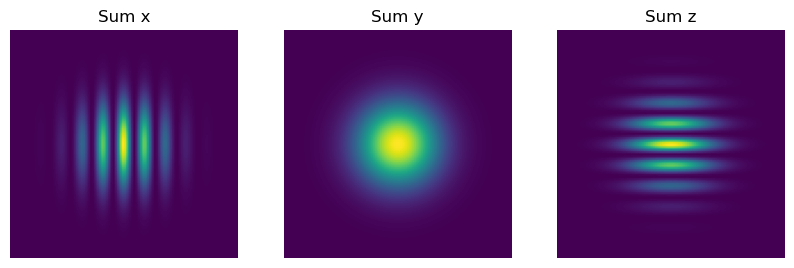

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(pdf_vals.sum(dim=0).T, origin='lower')
ax[0].set_title('Sum x')
ax[0].axis('off')

ax[1].imshow(pdf_vals.sum(dim=1).T, origin='lower')
ax[1].set_title('Sum y')
ax[1].axis('off')

ax[2].imshow(pdf_vals.sum(dim=2).T, origin='lower')
ax[2].set_title('Sum z')
ax[2].axis('off')
plt.show()

The object to be imaged in gradoptics is called a light source. In our case, we can define a light source from this atom cloud distribution very simply by wrapping it in the `LightSourceFromDistribution` class.

In [6]:
light_source = optics.LightSourceFromDistribution(atom_cloud_distribution)

while the atom cloud distribution defines all of the properties associated with the density itself, `LightSourceFromDistribution` uses these to interface with `Rays` -- the fundamental object for the rendering procedure. 

## Setting up a camera

In order to have an image, we need to have something to capture the image. In `gradoptics`, a camera has two fundamental components: a `Lens` and a `Sensor`. We have implemented both thin and thick lenses -- for simplicity, we'll assume a thin lens here (`PerfectLens`).

Note that lenses can be composed for more complex optics! They're just objects with lens properties, sitting in space.

### PerfectLens

gradoptics has a default camera orientation along `+x`. Since our cloud is at `(0, 0, 0)`, we'll put the camera at some fixed position in `-x`. We want our image to be in focus, so let's use the lensmaker's formula, assuming some values for position and magnification, to calculate an appropriate lens focal length. We can, of course, fix any two of these and calculate the third.

In [7]:
def calculate_focal_length(m, obj_distance):
    f =  obj_distance / ((1 / m) + 1)

    return f

In [8]:
camera_pos = torch.tensor([-0.06, 0, 0])
obj_distance = torch.norm(camera_pos-light_source.distribution.position)
m = 0.1
f= calculate_focal_length(m, obj_distance)

We also need to define the numerical aperture of the camera, which effects the amount of light we will collect. Usually this is expressed via the lens f-number.

In [9]:
# Numerical aperture (size of camera opening, f-number)
na = 1/1.4

With all of these characteristics, we can then define a lens

In [10]:
lens = optics.PerfectLens(f=f, na=na, position=list(camera_pos), m=m)

### Sensor

The sensor collects the light to make the final image. For an in focus image, we can calculate the position of the sensor relative to the lens.

In [11]:
rel_position = torch.tensor([-f * (1 + m), 0, 0])      
sensor_position = camera_pos + rel_position

We then need to define properties like the camera **resolution** and **pixel size** as well as other characteristics like quantum efficiency and poisson noise. Viewing direction controls the sensor orientation, and should be pointing towards the lens. We make some choices here for you. Reminder that pixel size, e.g. is in meters.

In [12]:
sensor = optics.Sensor(position=sensor_position, viewing_direction=(1,0,0),
                       resolution=(200,200), pixel_size=(2.4e-06, 2.4e-06),
                       poisson_noise_mean=2, quantum_efficiency=1)

### Cameras
For convenience, the lens and sensor system can be packaged up in a `Camera` object, which also ensures that any light reaching the sensor passes through the lens. For demonstration purposes, this isn't always the most convenient, but as an example:

In [13]:
camera = optics.Camera(lens, sensor)

## Making a scene!

All of the optical components in gradoptics get wrapped up in a `Scene` object, which will get used in the rendering. This is defined as:

In [14]:
scene = optics.Scene(light_source)
scene.add_object(sensor)
scene.add_object(lens)

We can then plot our optical setup

/sdf/group/mli/sgaz/anaconda3/envs/ml/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1704987277512/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


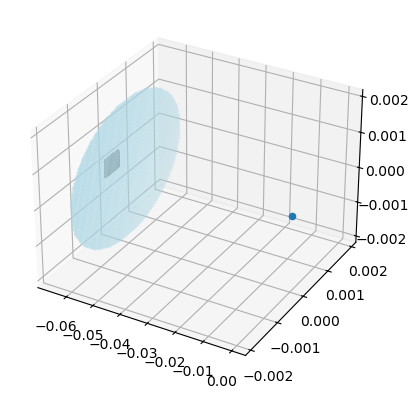

In [15]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
scene.plot(ax)

# Rendering an image

Now that we have our optical components and our atom cloud, all that remains is to do the actual image generation. We do so via a procedure called _ray-tracing_. 


A ray is defined by an origin $\mathbf{o}$ and a direction $\mathbf{d}$, with a given point along a ray at time $t$ given by


\begin{equation}
\mathbf{r}(t) = \mathbf{o} + t\cdot \mathbf{d}
\end{equation}


There are two common modes of tracing rays for image generation.

## Forward ray tracing

In forward ray tracing, we generate light rays from the light source, and follow them all the way to the camera sensor. This mimics how light is actually produced. However it can be inefficient -- we end up generating a lot of rays that never make it to the sensor. Let's look at this, and learn how to work with rays in the meantime.

To generate rays from a light source, we just use the sample rays method (let's keep it small with n_rays=100 for now).

In [16]:
rays = scene.light_source.sample_rays(100, device='cpu')

Each ray has an origin and a direction, accessed via `rays.origins` and `rays.directions`. Let's plot line segments for each point.

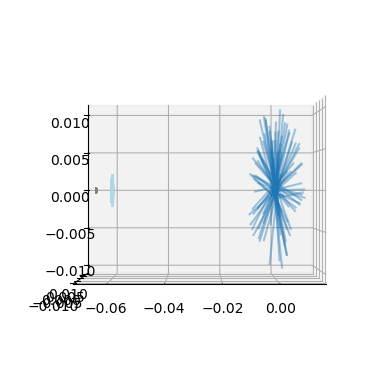

In [17]:
# t = 0
start = rays.origins

# t = 0.01
end = rays.origins + 0.01*rays.directions

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for i in range(len(start)):
    ax.plot([start[i, 0], end[i, 0]], 
            [start[i, 1], end[i, 1]],
            [start[i, 2], end[i, 2]], c='C0', alpha=0.4)
scene.plot(ax)
ax.view_init(0, -90)
plt.show()

We can follow these rays through the scene until they hit the sensor. Procedurally, we take each ray, check if it intersects an object in the scene, adjust the ray accordingly, and repeat. This loop is wrapped up in a `forward_ray_tracing` call, and the max number of these steps a ray is allowed ot take is set by `max_iterations`. In this case, we just have cloud to lens, lens to sensor (so `max_iterations = 2`).

In [18]:
optics.forward_ray_tracing(rays, scene, max_iterations=2)

The sensor object keeps track of which rays intersect. We can then get the resulting image by calling readout. This is where point spread function (PSF) effects are computed

In [19]:
image = scene.objects[0].readout(add_poisson_noise=False, destructive_readout=True)

We've only traced 100 rays, so we don't expect much signal.

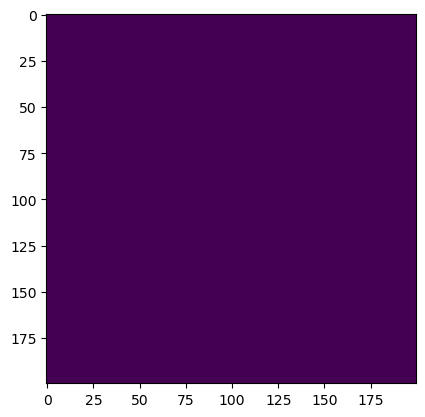

In [20]:
plt.imshow(image.cpu())
plt.show()

To generate a meaningful image, we need to trace many more rays. Since we have finite memory, we usually need to do this in batches. We wrap this up in a function for convenience:

In [21]:
def make_image(scene, device='cpu', nb_rays=int(1e9), batch_size=int(50e6), quantum_efficiency=True, max_iterations=2,
               add_poisson_noise=True, lookup_table=None, show_progress=True, destructive_readout=True):
    
    progress_bar = tqdm if show_progress else lambda x: x
    nb_rays_left_to_sample = nb_rays
    for _ in progress_bar(range(int(np.ceil(nb_rays / batch_size)))):
        rays = scene.light_source.sample_rays(min(batch_size, nb_rays_left_to_sample), device=device)
        
        optics.forward_ray_tracing(rays, scene, max_iterations=max_iterations)
        nb_rays_left_to_sample -= batch_size

        del rays
        torch.cuda.empty_cache()

    return scene.objects[0].readout(add_poisson_noise=add_poisson_noise, destructive_readout=destructive_readout)

In [22]:
image_forward = make_image(scene, nb_rays=int(1e8),device='cuda', add_poisson_noise=False)

100%|██████████| 2/2 [00:11<00:00,  5.89s/it]


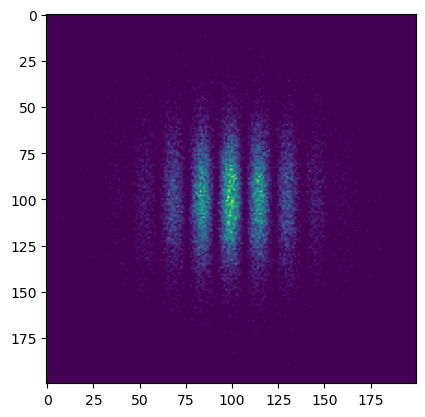

In [23]:
plt.imshow(image_forward.cpu())
plt.show()

Still a bit noisy -- but we see the structure! To sharpen the image even more, we'll need to trace more rays -- feel free to try it!

### Hardware note
We are using the GPU (cuda) here. Using CPU is much much slower (at the time of running here, >10x). Feel free to try running -- but it'll take a while:

In [114]:
image_forward = make_image(scene, nb_rays=int(1e8), device='cpu', add_poisson_noise=False)

100%|██████████| 2/2 [01:01<00:00, 30.90s/it]


## Backward ray tracing

In practice it is often more convenient to use backward ray tracing for rendering. This only deals with the light that actually reaches the sensor, allowing us to trace many fewer rays. There are a couple of subtleties here, so we will break it down.

The key idea of backward ray tracing is that, instead of starting rays at the light source, we start rays at each pixel. The backward part here is that we then trace these rays all the way back to the light source.

### Constructing backward rays

Let's get the pixel coordinates for the sensor we defined above. For simplicity, we will only consider rays at the center of each pixel. When it comes to dealing with pixel coordinates, there's a useful set of transformations describing how to translate from coordinates on the _2D camera plane_ to coordinates in the _3D world_. What this means for us is we can get pixel centers in a 2D x-y plane.

**Big note:** Keeping coordinate systems and sign conventions straight can be a pain (see, e.g. the minus signs in the below cell). Always a good thing to double check -- comparisons with forward ray tracing are useful here.

In [61]:
sensor = scene.objects[0]

# Pixel coordinates in camera space
x = -torch.linspace(-sensor.pixel_size[0]*sensor.resolution[0]/2 + sensor.pixel_size[0]/2,
                     sensor.pixel_size[0]*sensor.resolution[0]/2 - sensor.pixel_size[0]/2, 
                     sensor.resolution[0])

y = -torch.linspace(-sensor.pixel_size[1]*sensor.resolution[1]/2 + sensor.pixel_size[1]/2,
                     sensor.pixel_size[1]*sensor.resolution[1]/2 - sensor.pixel_size[1]/2, 
                     sensor.resolution[1])


pix_x, pix_y = torch.meshgrid(x, y, indexing='xy')

Stack this up with an all zeros z coordinate

In [62]:
pix_z = torch.zeros((sensor.resolution[0], sensor.resolution[1]))

all_coords = torch.stack([pix_x, pix_y, pix_z], dim=-1).reshape((-1, 3)).double()

And then translate into world space with the appropriate transformation

In [63]:
pixel_centers = sensor.c2w.apply_transform_(all_coords)

In [64]:
pixel_centers

tensor([[-0.0660,  0.0002,  0.0002],
        [-0.0660,  0.0002,  0.0002],
        [-0.0660,  0.0002,  0.0002],
        ...,
        [-0.0660, -0.0002, -0.0002],
        [-0.0660, -0.0002, -0.0002],
        [-0.0660, -0.0002, -0.0002]], dtype=torch.float64)

where `c2w` = camera to world. This is useful if we're moving the camera sensor around -- we just let the c2w transformation handle any world space translation/rotation, and only ever need to worry about the flat pixel grid. Just to check:

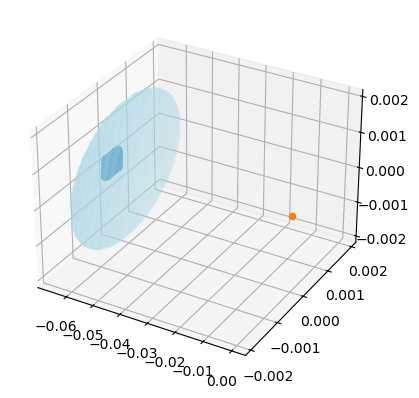

In [65]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(pixel_centers[:, 0], pixel_centers[:, 1], pixel_centers[:, 2])
scene.plot(ax)
plt.show()

In a function:

In [71]:
def get_pixel_coords(sensor):
    # Pixel coordinates in camera space
    x = -torch.linspace(-sensor.pixel_size[0]*sensor.resolution[0]/2 + sensor.pixel_size[0]/2,
                        sensor.pixel_size[0]*sensor.resolution[0]/2 - sensor.pixel_size[0]/2, 
                        sensor.resolution[0])

    y = -torch.linspace(-sensor.pixel_size[1]*sensor.resolution[1]/2 + sensor.pixel_size[1]/2,
                        sensor.pixel_size[1]*sensor.resolution[1]/2 - sensor.pixel_size[1]/2, 
                        sensor.resolution[1])
    
    pix_x, pix_y = torch.meshgrid(x, y, indexing='xy')
    
    pix_z = torch.zeros((sensor.resolution[0], sensor.resolution[1]))
    
    all_coords = torch.stack([pix_x, pix_y, pix_z], dim=-1).reshape((-1, 3)).double()
    
    # Use transforms from above setup to go from pixel space to real (world) space
    return sensor.c2w.apply_transform_(all_coords)

These positions are the origins of the rays. To complete the rays, we therefore need a set of directions. 


We note that the intensity we observe on a given pixel comes from light passing through our lens/camera aperture. If we look at forward ray tracing, light rays can come into the camera from all over the lens:

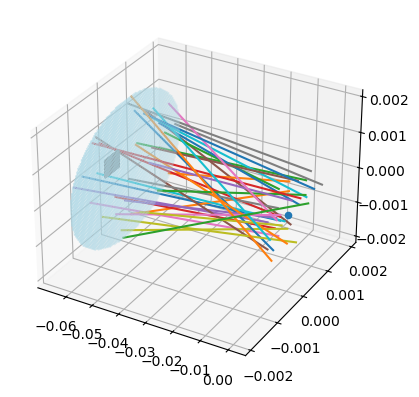

In [72]:
rays = scene.light_source.sample_rays(100000, device='cpu')
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

optics.forward_ray_tracing(rays, scene, max_iterations=2, ax=ax)
scene.plot(ax)
plt.show()

In backwards ray tracing, we therefore need to sample the direction of our rays over the lens surface -- we're calculating an integrated effect. For explanatory purposes (and sometimes in general), it is convenient to instead consider a _pinhole_ camera, where we only consider rays that pass through a small point (in our case, the center of the lens).

We will come back to simulating a full lens later!

### Pinhole camera model
First we get the center of the lens:

In [73]:
lens = scene.objects[1]

In [74]:
#Get directions to center of lens -- this is grabbing the translation component of a 4x4 matrix
lens_center = lens.transform.transform[:-1, -1]

Directions then should be pointing from the sensor to the lens -- can think about it as "what do i add to origins to get to the lens":

\begin{equation}
\mathbf{r} = \mathbf{o} + \mathbf{d} \implies \mathbf{d} = \mathbf{r} - \mathbf{o}
\end{equation}

In [75]:
origins = get_pixel_coords(scene.objects[0])

directions = lens_center - origins

And then we can construct rays

In [76]:
rays_sensor_to_lens = optics.Rays(origins, directions, device='cuda')

Note that directions get normalized to a norm of 1 behind the scenes!

In [77]:
print('original', directions[0])
print('normalized', directions[0]/torch.norm(directions[0]))
print('ray direction', rays_sensor_to_lens.directions[0])

original tensor([ 0.0060, -0.0002, -0.0002], dtype=torch.float64)
normalized tensor([ 0.9984, -0.0397, -0.0397], dtype=torch.float64)
ray direction tensor([ 0.9984, -0.0397, -0.0397], device='cuda:0', dtype=torch.float64)


Let's check that this is doing what we want!

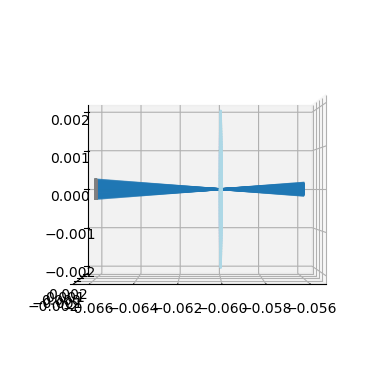

In [78]:
# t = 0
start = rays_sensor_to_lens.origins.cpu()

# t = 0.01
end = (rays_sensor_to_lens.origins + 0.01*rays_sensor_to_lens.directions).cpu()

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Only plot a subset -- we have 200*200 = 40000 rays
idxs = np.random.permutation(range(len(start)))[:100]
for i in idxs:
    ax.plot([start[i, 0], end[i, 0]], 
            [start[i, 1], end[i, 1]],
            [start[i, 2], end[i, 2]], c='C0', alpha=0.4)
sensor.plot(ax)
lens.plot(ax)
ax.view_init(0, -90)
plt.show()

### From rays to image

The contribution of each ray to an observed pixel intensity is via a line integral. This line integral is done via a Monte Carlo integration, where we sample points along the ray and sum them up. The most basic form of this integration would be a pure uniform sample along a given ray. A _stratified sampling_ approach is more common, where sampling is done in uniform bins along the ray. In _hierarchical sampling_, what we do here, additional samples are taken following calculation of importance weights to concentrate samples where the integral is non-zero.


So, what do we integrate? In our case, we have a transparent atom cloud, so the contribution of a ray to a given pixel intensity is proportional to the cloud density:
\begin{equation}
C(\mathbf{r}) \propto \int \sigma(\mathbf{r}(t))dt
\end{equation}

In other contexts, additional terms (such as a transmittance), may need to be included.

Most of this is buried behind the scenes, but two important pieces are needed on the user end: an `integrator`, defining the Monte Carlo line integral strategy:

In [79]:
# Define an integrator
from gradoptics.integrator import HierarchicalSamplingIntegrator

# 64 stratified points, 64 importance weighted points -- may need to adjust this number!
integrator = HierarchicalSamplingIntegrator(64, 64)

And a `bounding shape`, defining the integration region. This is usually a sphere surrounding the cloud of interest, and helps us be more efficient by focusing Monte Carlo samples around where we actually have density.

In [80]:
scene.light_source.bounding_shape = optics.BoundingSphere(radii=0.01, 
                                                           xc=0, yc=0, zc=0)

The ray tracing and integration are then just done via:

In [81]:
image_pinhole = optics.backward_ray_tracing(rays_sensor_to_lens, scene, 
                                          scene.light_source, integrator, max_iterations=2)

# Output is flat -- need to reshape into image shape
image_pinhole = image_pinhole.reshape(scene.objects[0].resolution).cpu()

Resulting in an image:

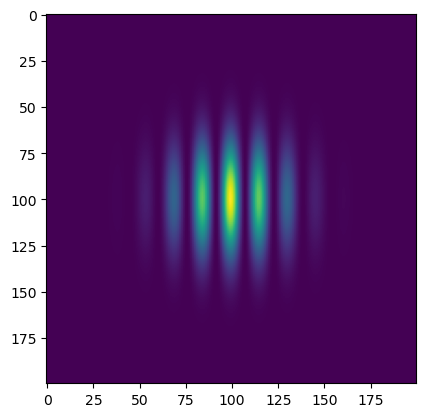

In [82]:
plt.imshow(image_pinhole)
plt.show()

which just looks like a projection of our density. This is almost correct, but not quite -- there are a few factors needed for various effects in the integration. We'll just expose them here. Using these factors for the pinhole case is sweeping a couple of things under the rug -- but useful to see!

In [83]:
# cos_theta factor -- lens intensity falloff 
sensor_normal = (lens_center- sensor.position)
sensor_normal = sensor_normal*1./torch.norm(sensor_normal)
cos_theta = optics.optics.vector.cos_theta(sensor_normal[None, ...], directions.reshape(-1,3)).cuda()


# Distance between sensor and lens
z = torch.norm((lens_center - sensor.position))

# Sensor and lens area
pa = 1 / (sensor.resolution[0] * sensor.pixel_size[0] * 
          sensor.resolution[1] * sensor.pixel_size[1])
lens_radius = lens.f * lens.na / 2
factor = 1/z**2 * (np.pi * lens_radius**2) * 1/pa


image_pinhole = optics.backward_ray_tracing(rays_sensor_to_lens, 
                                          scene, scene.light_source, 
                                          integrator, max_iterations=2)

image_pinhole = factor*(image_pinhole*cos_theta**4).reshape(sensor.resolution).cpu()

To properly compare forward and backward, we also need to account for the number of emitted/collected rays.

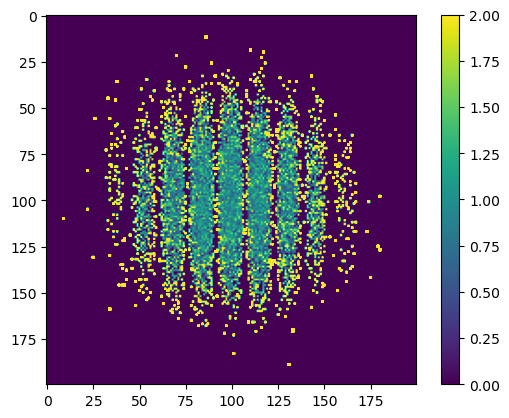

In [84]:
plt.imshow((image_forward.cpu().numpy()/(1e8/(4*np.pi)))/(image_pinhole.cpu()/(200*200)), vmin=0, vmax=2)
plt.colorbar()
plt.show()

Pretty close! Let's wrap the pinhole camera image in a function for convenience:

In [85]:
def create_image_pinhole(scene):
    sensor = scene.objects[0]
    lens = scene.objects[1]

    #Get directions to center of lens -- this is grabbing the translation component of a 4x4 matrix
    lens_center = lens.transform.transform[:-1, -1]

    origins = get_pixel_coords(sensor)

    directions = lens_center - origins


    rays_sensor_to_lens = optics.Rays(origins, directions, device='cuda')

    # cos_theta factor -- lens intensity falloff 
    sensor_normal = (lens_center- sensor.position)
    sensor_normal = sensor_normal*1./torch.norm(sensor_normal)
    cos_theta = optics.optics.vector.cos_theta(sensor_normal[None, ...], directions.reshape(-1,3)).cuda()


    # Distance between sensor and lens
    z = torch.norm((lens_center - sensor.position))

    # Sensor and lens area
    pa = 1 / (sensor.resolution[0] * sensor.pixel_size[0] * 
              sensor.resolution[1] * sensor.pixel_size[1])
    lens_radius = lens.f * lens.na / 2
    factor = 1/z**2 * (np.pi * lens_radius**2) * 1/pa


    image_pinhole = optics.backward_ray_tracing(rays_sensor_to_lens, 
                                              scene, scene.light_source, 
                                              integrator, max_iterations=2)

    image_pinhole = factor*(image_pinhole*cos_theta**4).reshape(sensor.resolution).cpu()
    
    return image_pinhole

## Lens models and backward ray tracing

The procedure to include a lens model is to include rays that pass through more parts of the lens than just the center.

Why do we need a lens model? This accounts for realistic camera effects, such as _geometric blur_.

There are a variety of ways implement this. We'll quickly show one option, contained in the `render_pixels` function. This does a uniform sampling over the lens disk to set ray directions.

In [188]:
def create_im_backward(scene):
    sensor = scene.objects[0]
    lens = scene.objects[1]
    
    # Pixel indices
    idxs = torch.cartesian_prod(torch.arange(sensor.resolution[0]//2, -sensor.resolution[0]//2, -1), 
                                torch.arange(sensor.resolution[1]//2, -sensor.resolution[1]//2, -1))

    pix_x, pix_y = idxs.T


    # Batch rays for computation
    batch_size = 4000

    pix_x = pix_x.split(batch_size)
    pix_y = pix_y.split(batch_size)

    all_intensities = []
    for batch_pix_x, batch_pix_y in tqdm(list(zip(pix_x, pix_y))):
        intensities = optics.ray_tracing.ray_tracing.render_pixels(sensor, 
                                                                   lens,
                                                                   scene, scene.light_source, 
                                                                   10, 10, batch_pix_x,
                                                                   batch_pix_y, 
                                                                   integrator, device='cuda', max_iterations=2)


        all_intensities.append(intensities.clone())

    # Collect all the results
    im_back_lens = torch.cat(all_intensities).reshape(scene.objects[0].resolution).T
    
    return im_back_lens

In [192]:
im_back_lens = create_im_backward(scene)

100%|██████████| 10/10 [00:01<00:00,  6.85it/s]


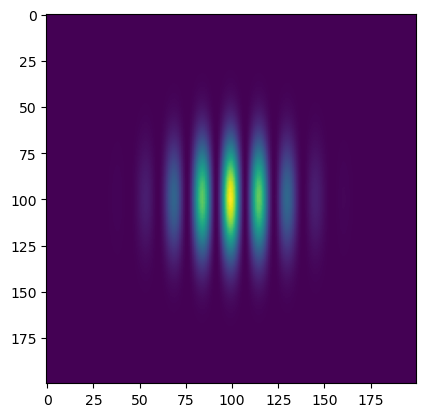

In [193]:
plt.imshow(im_back_lens.cpu())

Not a lot of difference -- but let's move a little out of focus

In [200]:
scene.light_source.distribution.position = torch.tensor([0.01, 0., 0.])

The pinhole image doesn't include the lens model, so won't experience the same defocus effects

In [201]:
im_pin = create_image_pinhole(scene)

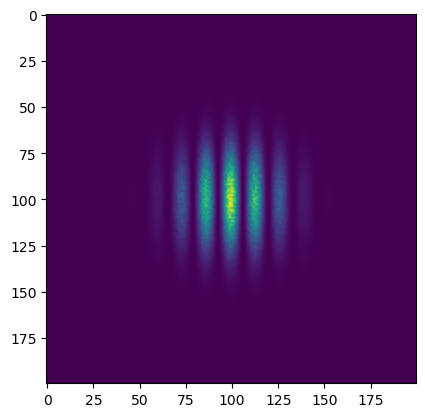

In [202]:
plt.imshow(im_pin)
plt.show()

However our lens model will:

In [206]:
im_back_lens_blur = create_im_backward(scene)

100%|██████████| 10/10 [00:01<00:00,  6.80it/s]


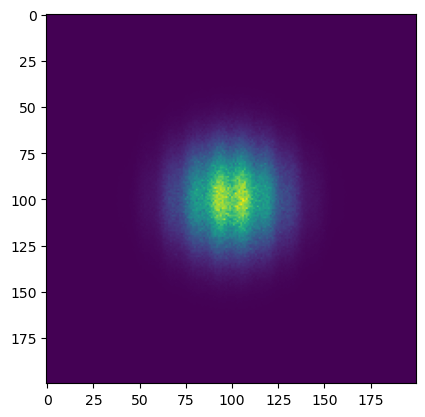

In [205]:
plt.imshow(im_back_lens.cpu())
plt.show()

We can tune the number of rays in the lens integration to smooth this out. Just to check against forward ray tracing:

In [207]:
image_forward_blur = make_image(scene, nb_rays=int(1e8),device='cuda', add_poisson_noise=False)

100%|██████████| 2/2 [00:11<00:00,  5.60s/it]


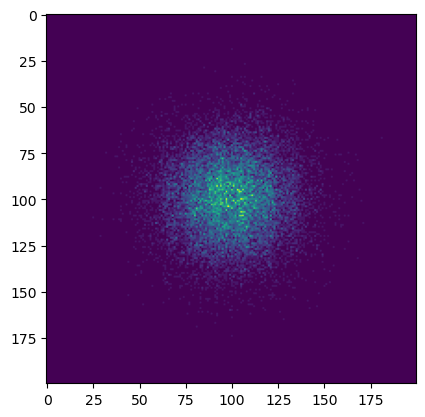

In [208]:
plt.imshow(image_forward_blur.cpu())
plt.show()

Similar defocus! Though will need more rays to sharpen the image (see why we like backward ray tracing?)